## <span style="color:blue"> Computer Vision - Winter 2024

## <span style="color:blue"> Exercise 2 </span>
**Reichman University**

**Lecturer:** Prof. Yael Moses, RUNI

**TA:** Eyal Friedman, RUNI

**Submission date: 25.1.24** \
Note: In case you need an extension for any reason, you can submit it by 29.1.24. \
No extra extensions will be given.
In case you are in miluim - please contact Yael directly.

**Your name: Gal Moshkovitch, Tom Sabag**
**Your ID: 315848929, 208845842**

In this exercise, you will implement:
    
1. Straight line detection from image features using  Hough Transform.
2. Various feature matching.
3. Computing depth from rectified images.


## <span style="color:blue"> Submission guidelines:</span>

1. Your **zip** file should include the following files only:
   - ex2.ipynb
   - images you use that were not given
2. You should use Jupyter Notebook.
3. Name the zip file **'ex2_ID_ID.zip'** and **do not** include any additional directories.
4. Submit using *Moodle*.
5. Submit on time!
6. You can submit this assignment in pairs (no triplets).
   * In the case of pair submission, both IDs and names should be added to the notebook.
   * One should submit the homework, and the other should submit a simple text file named: ID_ID.txt and nothing else.
   *Please make sure that your collaborator submits the HW.

## Read the following instructions carefully:

1. Write **efficient vectorized** code. When you think you cannot use vectorized code, give a short explanation of why.
2. You are responsible for the correctness of your code and should add as many tests as you see fit. Do not submit your tests unless requested.
3. Use `Python 3` and `numpy 1.18.5` or above. Changes to the configuration we provided are at your own risk. Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works.
4. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden unless provided by us.
5. Your code must run without errors. Note, **Code that fails to run will not be graded.**
6. Document your code properly.
7. Go over Warmup Python - you can find relevant python functions that will make your life easier.



## Honor Code:
The assignment is a basic tool for learning the material. You can probably find the solution on the web (including ChatGPT), however, you will not learn what you should learn from it. In addition, since we give grades on the assignment, using existing solutions will be considered dishonest.
In particular, you are not allowed to copy or use any code that solve the tasks.
You are more than welcome to talk with your friends, but you are not allowed to give your code or answers and you are not allowed to use their code or answers.
Remember – you take this course in order to learn.

## I declair that I respcet the honor code:
<span style="color:red"> Add here your names: Gal Moshkovitch, Tom Sabag


In [1]:
import cv2


from matplotlib import pyplot as plt

# This opens an inteactive figure - use it in part B
import matplotlib
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space
from scipy.signal import convolve2d

# This specifies the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'


import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.9.17
Numpy version:  1.26.3




## <span style="color:blue">Section A: Detect a Straight Lines

In this part you will use the set of edge points to detect straight lines in an image.\
The input will consist of edge points computed by the Canny edge detector - you can use the implementation of CV2, which is demonstrated below.\
    The output will be a set of straight lines in the image. There are two main methods to compute straight lines from such input: the Hough transform and RANSAC. You will implement the Hough transform.

    

**Hough transform**\
Every 2D line, $\ell$,   can be represented by 2 parameters:  $r$ and $\theta$ where all points on the lines satisfy $r=(xcos\theta, ysin\theta)$.
Let $P_0=(x_0,y_0)$ be the intersection of a normal to $\ell$ from the origin.
The distance between $P_0$ and the origin is given by $r$ and the angle between the normal and the $x$ axis is given by $\theta$.






**Your goal:**     Write the following function\
Straight_lines(image_file, res_r, res_orient,min_number_points,display,  ...)\
    You can add any other parameters that you need.
    


 To do so, you need also to define the following functions.
 You can add parameters to the functions, as long as you  provide clear explanations of their roles and purposes.

In [2]:
def non_maximum_suppression(corners, density_size):
  corners = corners.copy()
  padding = density_size // 2
  height, width = corners.shape
  suppressed_img = np.zeros_like(corners)

  corners_index = np.argwhere(corners)
  for x, y in corners_index:
    if padding <= x <= height - padding and padding <= y <= width - padding:
      local_maximum = np.max(corners[x-padding : x+padding+1, y-padding : y+padding+1])
      corner_strength = corners[x,y]
      if corner_strength == local_maximum :
        corners[x-padding : x+padding+1, y-padding : y+padding+1] = 0
        suppressed_img[x, y] = local_maximum
  return suppressed_img

In [3]:
# Input: a set of edge points (or corners), and the resolution of the distance and angles.
# output: the Hough matrix (H) containing votes for lines represented by r and θ.

# Added parameter: img_shape. the maximal value of rho is calculated using the width and height of the image
def H_matrix(L_points, resolution_r, resolution_ang, img_shape):
  H = np.zeros((resolution_r, resolution_ang))

  width, height = img_shape
  max_r = np.linalg.norm([width, height])

  r_step_size = max_r / resolution_r
  r_range = np.arange(0, max_r, r_step_size)

  deg_step_size = 180/resolution_ang
  degrees = np.arange(0, 180, deg_step_size)
  ang_range = np.radians(degrees)

  cos_thetas = np.cos(ang_range).reshape((1,-1))
  sin_thetas = np.sin(ang_range).reshape((1,-1))

  Xs = L_points[0].reshape(-1, 1)
  Ys = L_points[1].reshape(-1, 1)

  rhos = Xs @ cos_thetas + Ys @ sin_thetas
  rhos_indices = np.rint(rhos / r_step_size).astype(int)


  for angle_index in range(resolution_ang):
    unique_rhos_indices, counts = np.unique(rhos_indices[:, angle_index], return_counts=True)
    unique_rhos_indices[unique_rhos_indices == resolution_r] = resolution_r-1

    H[unique_rhos_indices, angle_index] = counts

  return H, r_range, ang_range


# Input: The Hough matrix $H$, and a threshold for the number of minimal points on the line.
# output a list of triplets:  $(r, \Theta, num_points)$ where
# num_points is the number of points on that line.

# Added parameter: nms_density_size: non-maximum suppression neighbourhood size.
# This improved the results of the algorithm, eliminating closer lines which were detected as unique.
def list_lines(H, th, r_range, ang_range, nms_density_size):
  if nms_density_size > 0:
    H = non_maximum_suppression(H, nms_density_size)
  indices = np.where(H >= th)
  rhos = r_range[indices[0]]
  angles = ang_range[indices[1]]
  lines_strength = H[indices]
  lines = [(rhos[i], angles[i], lines_strength[i]) for i in range(rhos.shape[0])]
  return lines

# Display the detected lines in red - overlaid the original image
# Note: one way to do is, is to add the red lines to the image, and then display it
def display_lines(im, list_lines, display):
  lines = np.array([np.array(t) for t in list_lines])
  rhos = lines[:, 0]
  angles = lines[:, 1]

  x_1 = np.zeros(len(list_lines), dtype=int)
  x_1[angles == 0] = rhos[angles == 0]

  x_2 = np.full(len(list_lines), im.shape[0], dtype=int)
  x_2[angles == 0] = rhos[angles == 0]

  sin_angles = np.sin(angles)
  cos_angles = np.cos(angles)
  zero_angles_mask = 1 - np.isclose(sin_angles, 0, atol=0.001)
  sin_angles = np.where(sin_angles == 0, 0.0001, sin_angles)

  y_1 = np.where(zero_angles_mask, rhos / sin_angles, 0).astype(int)
  y_2 = np.where(zero_angles_mask, (rhos - x_2 * cos_angles) / sin_angles, im.shape[1]).astype(int)

  for i in range(len(list_lines)):
    color = (0, 0, 255)
    cv2.line(im, (y_1[i], x_1[i]), (y_2[i], x_2[i]), color, 1)
  if display:
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.show()
  return im


In [4]:
#Now use the above functions to implement
# Added parameter: nms_density_size: non-maximum suppression neighbourhood size.
# This improved the results of the algorithm, eliminating closer lines which were detected as unique.
def straight_lines(image_file, res_r, res_orient, min_number_points, display, print_num_lines=False, nms_density_size=-1):
  img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

  edges = cv2.Canny(img,250,500,5)
  edges_list = np.where(edges)

  h_matrix, r_range, ang_range = H_matrix(edges_list, res_r, res_orient, img.shape)
  lines = list_lines(h_matrix, min_number_points, r_range, ang_range, nms_density_size)
  if print_num_lines:
    print("Number of detected lines: ", len(lines))
  color_img = cv2.imread(image_file)

  return display_lines(color_img, lines, display)

**Apply and answer**

1. Generate a synthetic image to test your Hough Transform algorithm.
   * Submit the image as well as the results.


2. Apply your algorithm to the following images: Crosswalk, linesOnTheRoadGray, Sudoku.
   * Choose a set of parameters so the results looks fine.
   * You may need different parameters for each image.
   * Display the results.
   
   
3. **Answer**: How the resolutions of $r$ and $\theta$ affect the results?
   * Display images that demonstarte your answer.
   
   
4. Choose one image and **answer**: how many straight lines did you find with more than 50 points?
   * Display these lines on the image.
   
   
5. Suggest an algorithm to compute the length of the line in the image.
   * Describe the algorithm without implementing it.
   
   
6. Suggest three applications to use the results of straight line detection in an image.



#**Answer A.1**
In this simple example. we generated multiple shapes using powerpoint.

As visualized below, given a tuned set of hyper-parameters, the hough transform algorithm performs well and catches the vast majority of the lines.

**Set of Parameters:**

$
\rho \space resolution = 550
$

$
\theta \space resolution = 20
$

Threshold = 60

Number of detected lines = 26

Number of detected lines:  26


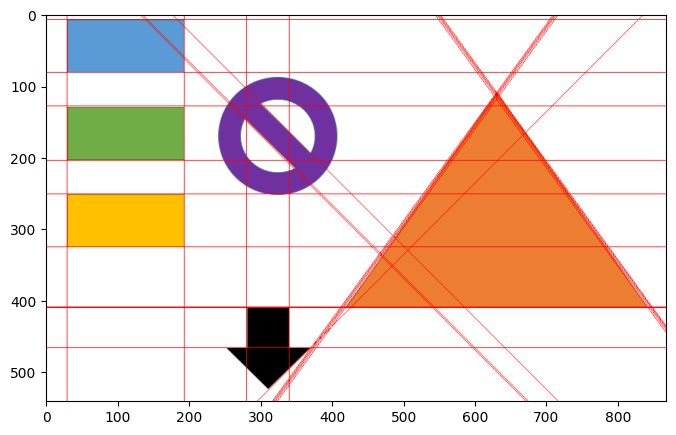

In [5]:
im = straight_lines("./images/shapes.png", 550, 20, 60, True, True)

# **Answer A.2**
Applying the hough transform to different images

Crosswalk

**Crosswalk**
**Set of Parameters:**

$
\rho \space resolution = 300
$

$
\theta \space resolution = 1
$

Threshold = 220

Number of detected lines = 19

Number of detected lines:  19


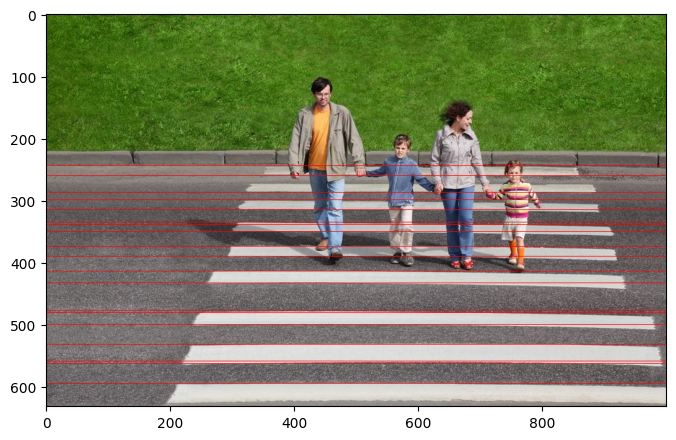

In [6]:
im = straight_lines("./images/Crosswalk.jpg", 300, 1, 220, True, True)

**Lines on the road**
**Set of Parameters:**

$
\rho \space resolution = 50
$

$
\theta \space resolution = 40
$

Threshold = 400

Non-maximum suppression density size = 11

Number of detected lines = 3

Number of detected lines:  3


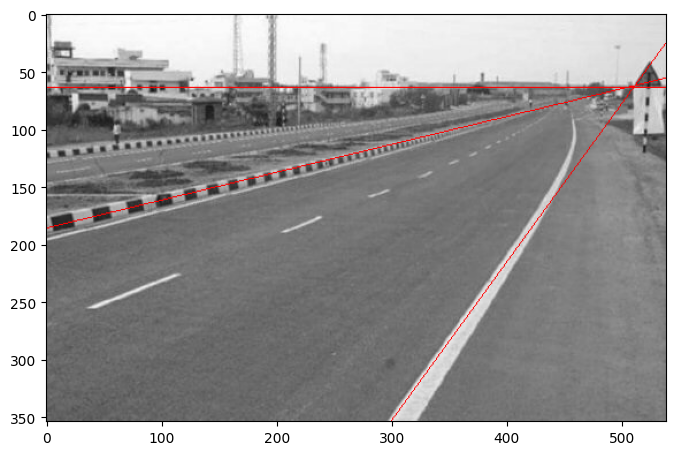

In [7]:
im = straight_lines("./images/linesOnTheRoadGray.jpg", 50, 40, 400, True, True)

**Soduko**
**Set of Parameters:**

$
\rho \space resolution = 5000
$

$
\theta \space resolution = 90
$

Threshold = 500

Number of detected lines = 39

Number of detected lines:  39


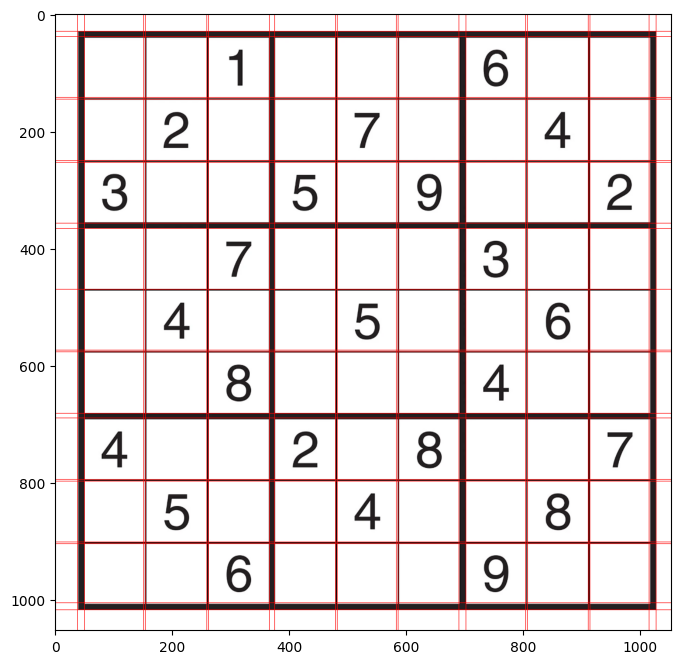

In [8]:
im = straight_lines("./images/Sudoku.PNG", 500, 90, 500, True, True)

#**Answer A.3**

**The effect of $\theta$ resolution**

$\theta \space$  parameter represents the angular resolution in polar coordinates of the hough accumulator array, the amount of columns in our implementation.

Less $\theta$ accumulator cells will result in a coarser angle resolution, meaning that lines at with similar angles may be represented in the same accumulator cell.

On the other hand, more $\theta$ accumulator cells will result in a finer angular resolution, allowing the accumulator array to distinguish between more lines.

**Left Image**
$\theta$ = 200
A larger value of $\theta$ is used to detect lines, resulting in finer angular resolution. As a result, as visualized below in this example, multiple lines with similar angles are detected as different lines.

**Right Image**

$\theta$ = 40
An adequate value for $\theta$ is used, resulting in the correct detection of all 3 lines on the road.

Number of detected lines:  18
Number of detected lines:  3


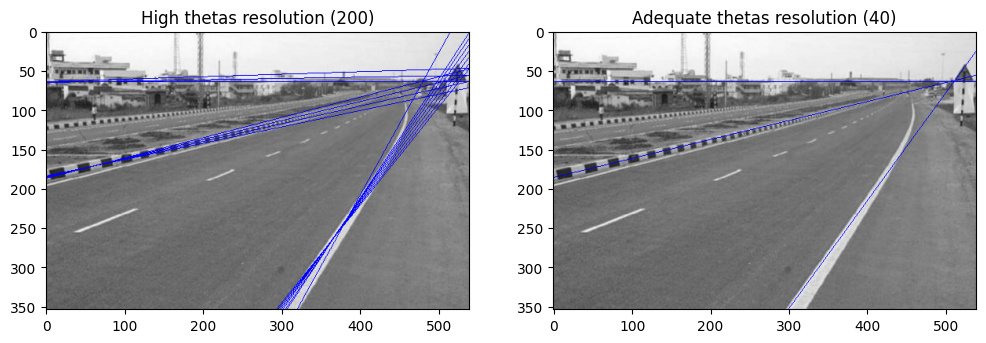

In [9]:
def theta_resolution_effect():
  road_high_thetas = straight_lines("./images/linesOnTheRoadGray.jpg", 50, 200, 400, display=False, print_num_lines=True)
  road = straight_lines("./images/linesOnTheRoadGray.jpg", 50, 40, 400, display=False, print_num_lines=True)

  fig, axes = plt.subplots(1, 2, figsize = (12, 9))
  axes[0].imshow(road_high_thetas)
  axes[0].set_title("High thetas resolution (200)")
  axes[1].imshow(road)
  axes[1].set_title("Adequate thetas resolution (40)")

theta_resolution_effect()

**The effect of $\rho$ resolution**:

$\rho$ parameter represents the distance resolution in polar coordinates of the hough accumulator array, the amount of rows in our implementation.

Less $\rho$ accumulator cells will result in a coarser resolution in terms of distance, meaning that lines at similar distances may be represented in the same accumulator cell.

On the other hand, more $\rho$ accumulator cells will result in a finer resolution, allowing the accumulator array to distinguish between lines at smaller distance intervals. However, they may fail to pass the same threshold in comparison to less $\rho$ cells.

**Left Image**

$\rho$ = 50
An adequate value for $\rho$ is used on the right handside, resulting in the correct detection of 3 lines on the road.

**Right Image**

$\rho$ = 70
A larger value of $\rho$ is used to detect lines, resulting in finer distance resolution. However, one of the lines fail to pass the same threshold as used for the previous image. The higher distance resolution resulted in less votes for the 3rd line, and more votes for closer lines in its neighbourhood, and as a result none of them passed the threshold.






Number of detected lines:  3
Number of detected lines:  2


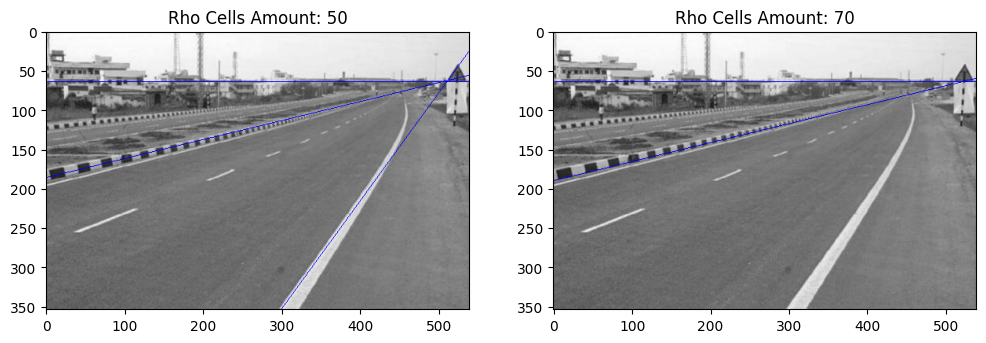

In [10]:
def rhos_resolution_effect():
  road = straight_lines("./images/linesOnTheRoadGray.jpg", 50, 40, 400, display=False, print_num_lines=True)
  road_more_rhos = straight_lines("./images/linesOnTheRoadGray.jpg", 70, 40, 400, display=False, print_num_lines=True)

  fig, axes = plt.subplots(1, 2, figsize = (12, 9))
  axes[0].imshow(road)
  axes[0].set_title("Rho Cells Amount: 50")
  axes[1].imshow(road_more_rhos)
  axes[1].set_title("Rho Cells Amount: 70")

rhos_resolution_effect()

#**A.4**

**Chosen image**:  linesOnTheRoadGray

**Set of Parameters:**

$
\rho \space resolution = 500
$

$
\theta \space resolution = 40
$

Threshold = 50

In this example, the amount of straight lines found with more than 50 votes is 33. if non max suppression is used, the algorithm performs very well and results in 5 lines.

Number of detected lines:  33


Number of detected lines:  5


Text(0.5, 1.0, 'Without suppression\n5 detected lines> 50 votes')

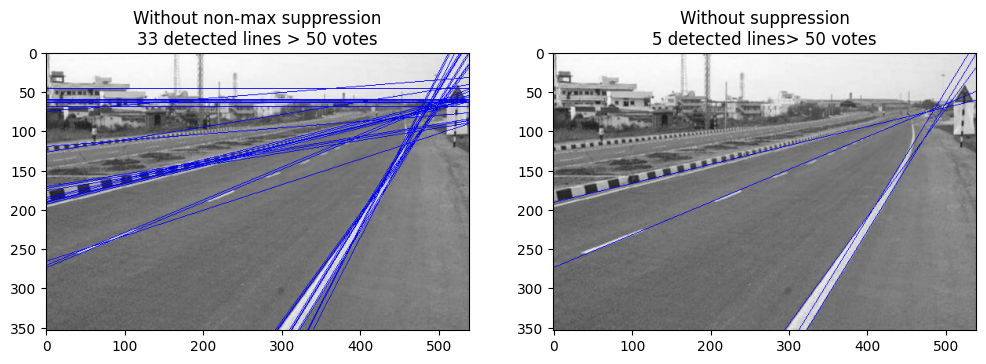

In [11]:
im_without_suppression = straight_lines("./images/linesOnTheRoadGray.jpg", 500, 40, 50, False, True)
im_with_suppression = straight_lines("./images/linesOnTheRoadGray.jpg", 500, 40, 50, False, True, 7)

fig, axes = plt.subplots(1, 2, figsize=(12, 9))

axes[0].imshow(im_without_suppression)
axes[0].set_title("Without non-max suppression\n33 detected lines > 50 votes")

axes[1].imshow(im_with_suppression)
axes[1].set_title("Without suppression\n5 detected lines> 50 votes")

#**A.5**

Algorithm Description
for an image of size $NxM$
1. **Setups:** Store all $\rho s$, $\theta s$ in a list

2. **Image-Line Intersection** For each pair ($\rho$, $\theta$) find line intersection with the image's borders. This can be calculated by plugging in X=0, N and Y=0, M to the following equation:

$
\rho = x\cdot cos(\theta) + y\cdot\sin(\theta)
$


Note: Two of the four points calculated intersect with the image's borders, while the other two dont. The correct points p1, p2 hold:

$
0 <= x <= N & 0 <= y <= M
$

3. **Distance Calculation**
Once found, line length can be calculated using euclidean norm:

Denote:

 $p1 = (x_1, y_1),\space\space
  p2=(x_2, y_2)$

Calculate the length of the line using euclidean norm:

$|| \ell || = \sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}$

#**A.6**
- Autonomous Vehicles (Lane Detection)
- Documents Processing (Scanning images)
- Building Mapping




Text(0.5, 1.0, 'Building Mapping')

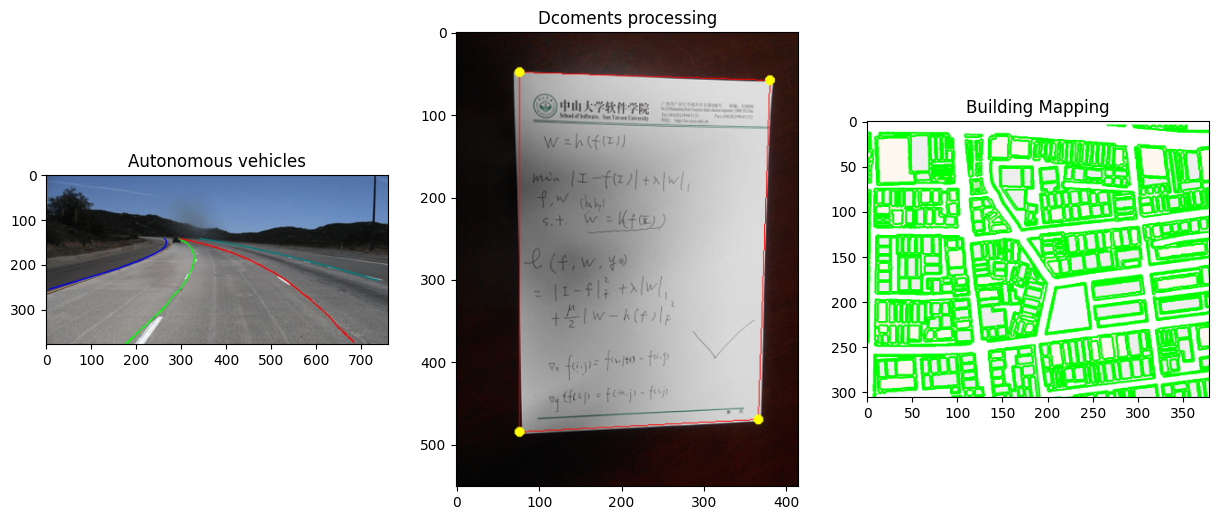

In [12]:
fig, axes = plt.subplots(1, 3, figsize = (15, 9))
autonomous = plt.imread("./images/autonomous.png")
doc = plt.imread("./images/document.png")
building = plt.imread("./images/building.png")

axes[0].imshow(autonomous)
axes[0].set_title("Autonomous vehicles")
axes[1].imshow(doc)
axes[1].set_title("Dcoments processing")
axes[2].imshow(building)
axes[2].set_title("Building Mapping")

## <span style="color:blue">Section B: Patch Matching
**In this part you will match intrest points between two images.**
    
    
There are two functions between vectors $v$ and $u$ that you will consider:\
a. Distance: Sum of Square Distance (SSD). That is,  $SSD(u,v)=(u-v)\cdot(u-v)$.\
b. Similarity: Normalized Cross Correlation (NCC). That is,  $NCC(u,v)={u\cdot v \over ||u||||v||}$.


The patch descriptor:
1. A vector with the pixels' grey level.
2. An histogram (30 bins) of the pixels' grey level.
3. A vector with the pixels' strength gradient.
4. An histogram (30 bins) of the pixels' strength of gradient.


In [13]:
#Implement the following functions:

# Input: two vectors
# Output distance (scalar) between two patches

def SSD(patch_descr_1, patch_descr_2):
  ssd_matrix = np.sum((patch_descr_1[:, np.newaxis, :] - patch_descr_2)**2, axis=2)
  np.fill_diagonal(ssd_matrix, 0)
  return ssd_matrix

# Input: two vectors
# Output normalized cross correlation  (scalar) between two patches

def NCC(patch_descr_1, patch_descr_2):
  norm1 = np.linalg.norm(patch_descr_1, axis = 1).reshape(-1, 1)
  norm2 = np.linalg.norm(patch_descr_2, axis = 1).reshape(1, -1)

  return (patch_descr_1 @ patch_descr_2.T) / (norm1 * norm2)


# Output a descriptor vector
# im is an image, p is a pixel, size is the patch size.
# You can use the histogram function of open cv or numpy

def patch_from_im(im, p, size):
  height, width = im.shape
  x, y = p
  size_x, size_y = size
  patch = im[max(0, x - size_x // 2) : min(x + size_x // 2 + 1, height),
             max(0, y - size_y // 2) : min(y + size_y //2 + 1, width)]
  return np.pad(patch, ((size_x - patch.shape[0], 0), (size_y - patch.shape[1], 0)))

def hist_patch_im(im,p,size):
  patch = patch_from_im(im, p, size)
  patch_vec = patch.flatten()
  hist, bin_edges = np.histogram(patch, bins=30)
  return hist

def gradient(im,p,size):
  G_x = np.array([[-1,0,1],
                  [-2,0,2],
                  [-1,0,1]])
  G_y = np.array([[1,2,1],
                  [0,0,0],
                  [-1,-2,-1]])
  patch = patch_from_im(im, p, size)
  im_Gx = convolve2d(patch, G_x,  mode='same')
  im_Gy = convolve2d(patch, G_y,  mode='same')
  patch_grad =  np.sqrt(im_Gx * im_Gx + im_Gy * im_Gy)
  return patch_grad.flatten()

def hist_gradient(im,p,size):
  patch_grad = gradient(im, p, size)
  hist, bin_edges = np.histogram(patch_grad, bins=30)
  return hist



1. Compute the corners in a pair of images (e.g., view0.tif and view6.tif).


**Apply and answer**


1. Compute the corners in a pair of images (e.g., view0.tif and view6.tif).


2. Choose up to 2000 of the strongest corners (you can use fewer) and find a matching between the corners in the pair of images.
    * Choose a fixed scale and use it to define a patch around each corner.
    * To display the matching, use the function cv2.hconcat([im1, im2]), which concatenates two images horizontally, and then draw lines as described in the previous section.


3. Use up to 4000 of the strongest corners (you can use fewer) in each image and use the matching only between corners that have approximately the same y-coordinate (up to a threshold).


4. Study the ratio for matching between the best and the second best match.
   * You can use NCC or SSD on the desriptor of your choice.
   * You can use without (2) or with (3) the $y$-coordinate constraint.
   * **Present** examples that demonstrate the effectiveness of using the ratio.


5. Study the differences between the different descriptors and also the use of SSD or NCC.
   * **Present**  examples that demonstrate your findings.


6. Identify incorrect pairs of matched points.\
   **Mark and display** for cases (2), (3), and (4) a pair of incorrectly matched points.\
   **Answer**\
   a. In which of the 3 cases are there more incorrect matches?\
   b. What may be the reason for the incorrect matches?


7. In which regions of the scene were most of the reliable matches found?



#**B.1**

Corner detection using the following set of parameters:

block_size = 3

sobel_kernel_size = 17

threshold = 0.001 from the max corner strength

NOTE: non-maximum suppression was applied for better results

corners amount: 954
corners amount: 1026


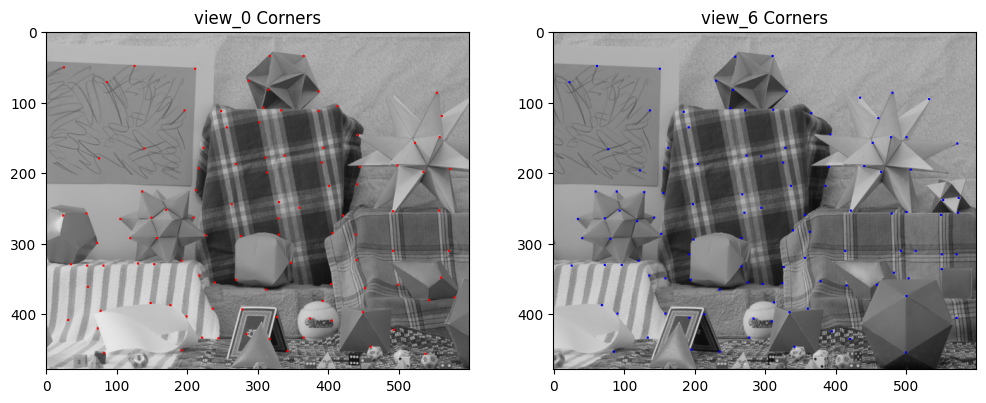

In [14]:
view0 = cv2.imread('./images/view0.tif')
view0_gray = cv2.cvtColor(view0,cv2.COLOR_BGR2GRAY).astype(np.int64)
view6 = cv2.imread('./images/view6.tif')
view6_gray = cv2.cvtColor(view6,cv2.COLOR_BGR2GRAY).astype(np.int64)

def cornerHarris(img, nms_density_size, block_size, sobel_kernel_size, th, color):
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  gray = np.float32(gray)
  dst = cv2.cornerHarris(gray, block_size, sobel_kernel_size, th)
  dst = non_maximum_suppression(dst, nms_density_size)
  dst = cv2.dilate(dst,None)
  dst_th = dst>th*dst.max()
  corners_pixels = np.where(dst_th)
  print("corners amount:", len(corners_pixels[0]))
  corners_strength = dst[dst_th]
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img[dst_th]=color
  return img, np.array(corners_pixels + (corners_strength,)).T

view0_img_corners, view0_corners = cornerHarris(view0, 41, 3, 17, 0.001, (255, 0, 0))
view6_img_corners, view6_corners = cornerHarris(view6, 41, 3, 17, 0.001, (0, 0, 255))

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize= (12.0, 9.0))
f.subplots_adjust(wspace = 0.2)
ax1.imshow(view0_img_corners), ax1.set_title('view_0 Corners')
ax2.imshow(view6_img_corners), ax2.set_title('view_6 Corners')
plt.show()

#**B.2**
Amount of strongest corners: 150

Fixed patch scale: (9, 9)

Visualized below:
- All detected corners overlayed on the image
- Strongest detected corners overlayed on the image
- Matched interest points of strongest corners


In [15]:
def calc_y_threshed_distances(img1_gray, img2_gray, strongest_corners1, strongest_corners2, descriptor_method, patch_size, y_thresh):
    strongest_corners1_indices = np.argsort(strongest_corners1[:, 0])
    strongest_corners2_indices = np.argsort(strongest_corners2[:, 0])

    sorted_strongest_corners1 = np.take(strongest_corners1, strongest_corners1_indices, axis=0)
    sorted_strongest_corners2 = np.take(strongest_corners2, strongest_corners2_indices, axis=0)

    descriptors_1 = np.vstack([descriptor_method(img1_gray, p, patch_size).flatten() for p in sorted_strongest_corners1])
    descriptors_2 = np.vstack([descriptor_method(img2_gray, p, patch_size).flatten() for p in sorted_strongest_corners2])

    distances = SSD(descriptors_1, descriptors_2)

    for i in range(distances.shape[0]):
      left = max(0, i - y_thresh//2)
      right = min(i + y_thresh//2, distances.shape[0])
      distances[i, :left] = 10 ** 15
      distances[i, right:] = 10 ** 15

    return distances, sorted_strongest_corners1, sorted_strongest_corners2

In [16]:
# corners - (x,y,strength) tuple of image corners
# num - the # of strongest corners
# output (x,y) pixels of num strongest corners
def get_strongest_corners(corners, num):
  sorted_corners = corners[corners[:,2].argsort()]
  strongest_corners = np.flip(sorted_corners, axis=0)
  return strongest_corners[:num,:2].astype(int)

def interest_points_matching(img1, img2, compare_by_distance, descriptor_method, num_corners, patch_size, colors, y_thresh=-1, ratio=-1, display=True):
  img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY).astype(np.int64)
  img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(np.int64)


  img1_with_corners, img1_corners_and_strength = cornerHarris(img1, 41, 3, 17, 0.001, colors[0])
  img2_with_corners, img2_corners_and_strength = cornerHarris(img2, 41, 3, 17, 0.001, colors[1])
  if display:
    f, ((ax1, ax2)) = plt.subplots(1, 2, figsize= (12.0, 9.0))
    f.subplots_adjust(wspace = 0.2)
    ax1.imshow(img1_with_corners), ax1.set_title('view_0 Corners')
    ax2.imshow(img2_with_corners), ax2.set_title('view_6 Corners')
    plt.show()

  strongest_corners1 = get_strongest_corners(img1_corners_and_strength, num_corners)
  strongest_corners2 = get_strongest_corners(img2_corners_and_strength, num_corners)

  img1_with_strongest_corners = img1.copy()
  img2_with_strongest_corners = img2.copy()

  for i in range(num_corners):
    x1, y1 = strongest_corners1[i, 0], strongest_corners1[i, 1]
    x2, y2 = strongest_corners2[i, 0], strongest_corners2[i, 1]
    cv2.circle(img1_with_strongest_corners, (y1, x1), 1, (0, 0, 255), 1)
    cv2.circle(img2_with_strongest_corners, (y2, x2), 1, (255, 0, 0), 1)

  descriptors_1 = np.vstack([descriptor_method(img1_gray, p, patch_size).flatten() for p in strongest_corners1])
  descriptors_2 = np.vstack([descriptor_method(img2_gray, p, patch_size).flatten() for p in strongest_corners2])

  distances = SSD(descriptors_1, descriptors_2) if compare_by_distance else 1 - NCC(descriptors_1, descriptors_2)

  if y_thresh != -1:
    distances, sorted_strongest_corners1, sorted_strongest_corners2 = calc_y_threshed_distances(img1_gray, img2_gray, strongest_corners1, strongest_corners2, descriptor_method, patch_size, y_thresh)

  np.fill_diagonal(distances, 10**15)
  match_indices = np.argmin(distances, axis=0)

  im_concat = np.hstack((img1_with_strongest_corners, img2_with_strongest_corners))


  min_values = np.min(distances, axis=1)
  second_min_values = np.partition(distances, kth=1, axis=1)[:, 1]
  ratios = min_values / second_min_values

  width = img1.shape[1]
  for index1, index2 in enumerate(match_indices):
    x1, y1 = strongest_corners1[index1]
    x2, y2 = strongest_corners2[index2]
    if y_thresh != -1:
      x1, y1 = sorted_strongest_corners1[index1]
      x2, y2 = sorted_strongest_corners2[index2]

    if y_thresh == -1 or np.abs(x1-x2) <= y_thresh:
      r = np.min(distances[index1, :]) / distances[index1, index2]
      if ratio == -1 or r < ratio:
        r, g, b = np.random.randint(0 , 256, 3)
        color = (int(r), int(g), int(b))
        cv2.line(im_concat, (y1, x1), (y2 + width, x2), color, 3)
  if display:
    plt.imshow(im_concat)
    plt.show()
  return im_concat

corners amount: 954
corners amount: 1026


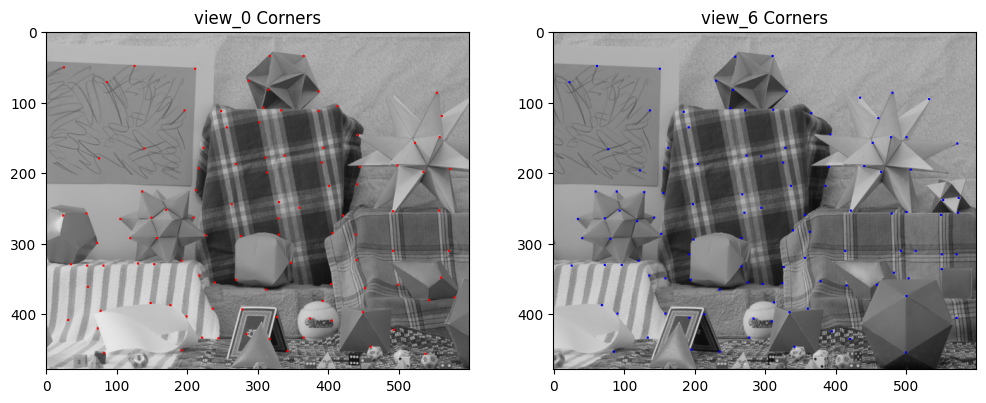

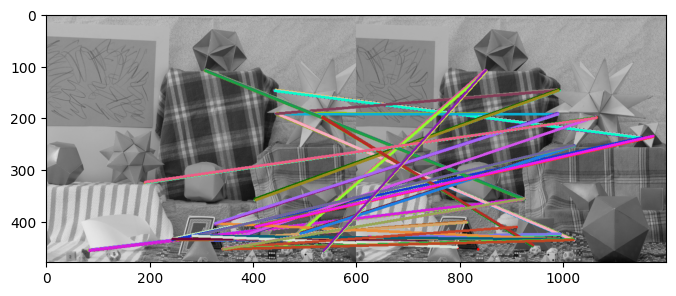

In [17]:
colors = [(255, 0, 0), (0, 0, 255)]
interest_points_matching(view0, view6, True, patch_from_im, 150, (9,9), colors)
plt.show()

#**B.3**
Amount of strongest corners: 120

Fixed patch scale: (9, 9)

Visualized below:
- All detected corners overlayed on the image
- Strongest detected corners overlayed on the image
- Matched interest points of strongest corners with similar y coordinates

As visualized below, matching points with same y coordinates significantly improves the algorithm's output.

corners amount: 954
corners amount: 1026


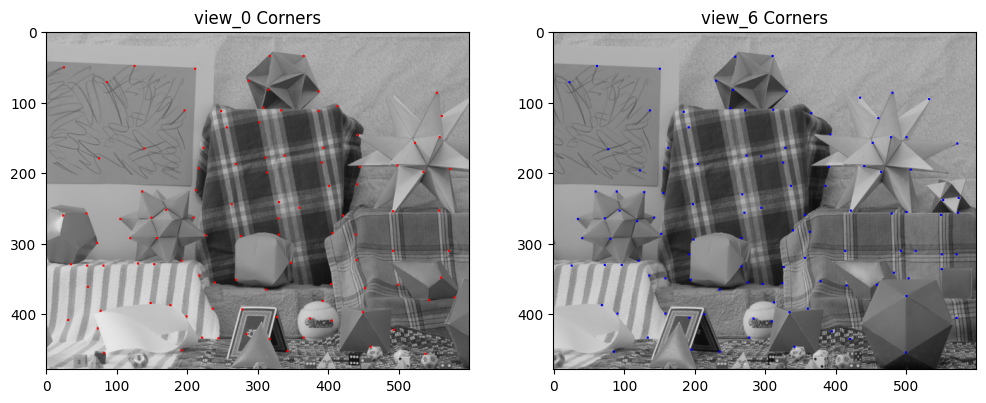

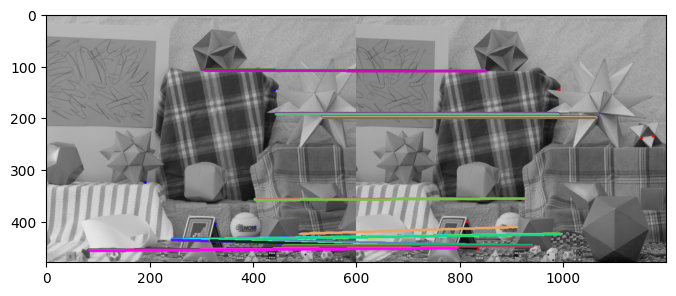

In [18]:
im = interest_points_matching(view0, view6, True, patch_from_im, 120, (9, 9), colors, 20)

#**B.4**

**Steps:**
- Calculate distances betweeen strongest corners
- Calculate for each corner its closest neighbour and 2nd closet neighbour
- Division and ratios estimation
- Ratios visualization using a histogram
- Effectiveness of using ratios: display corners with ratio < 0.2:
    * We applyed the algorithm without near y-coordinates thresholding
    * As visualized below, using ratios eliminated the vast majority of false detections, leaving only correct matches.

corners amount: 954
corners amount: 1026


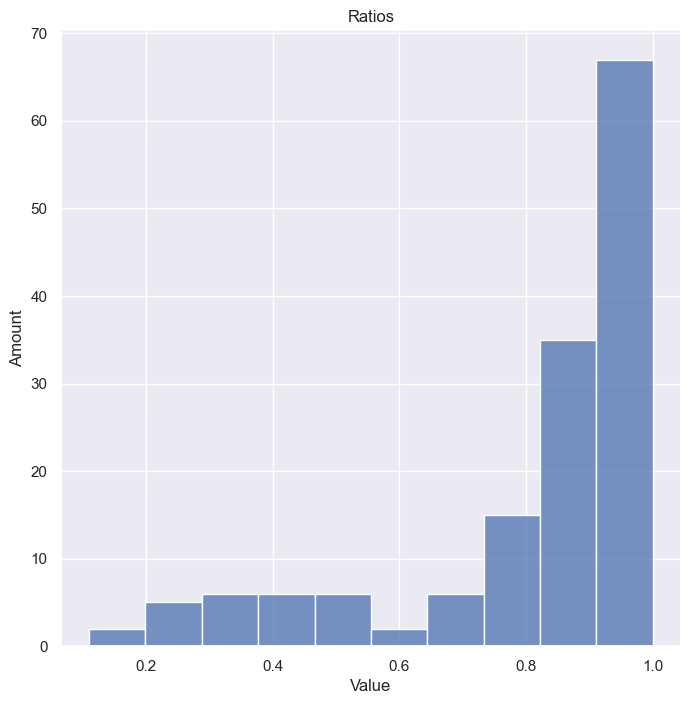

In [21]:
import seaborn as sns # This is a plotting library, making pyplot plots nicer :)

def study_distances_ratio(img1, img2, compare_by_distance, descriptor_method, num_corners, patch_size, y_thresh=-1):
  img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY).astype(np.int64)
  img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(np.int64)

  img1_with_corners, img1_corners_and_strength = cornerHarris(img1, 41, 3, 17, 0.001, (255, 0, 0))
  img2_with_corners, img2_corners_and_strength = cornerHarris(img2, 41, 3, 17, 0.001, (0, 0, 255))

  strongest_corners1 = get_strongest_corners(img1_corners_and_strength, num_corners)
  strongest_corners2 = get_strongest_corners(img2_corners_and_strength, num_corners)
  distances, _, _ = calc_y_threshed_distances(img1_gray, img2_gray, strongest_corners1, strongest_corners2, descriptor_method, patch_size, y_thresh)

  np.fill_diagonal(distances, 10**15)

  min_values = np.min(distances, axis=1)
  second_min_values = np.partition(distances, kth=1, axis=1)[:, 1]
  ratios = min_values / second_min_values

  sns.set()
  sns.histplot(ratios, bins=10)
  plt.title("Ratios")
  plt.xlabel("Value")
  plt.ylabel("Amount")
  plt.show()
  sns.reset_defaults()

study_distances_ratio(view0, view6, True, patch_from_im, 150, (9,9), 30)

Filtering with ratio < 0.2 example

Parameters:
- patch as a descriptor
- SSD distance
- 40 strongest corners
- Patch size (9, 9)
- Ratio: $\frac{best}{2nd-best}$ < 0.2

corners amount: 954
corners amount: 1026


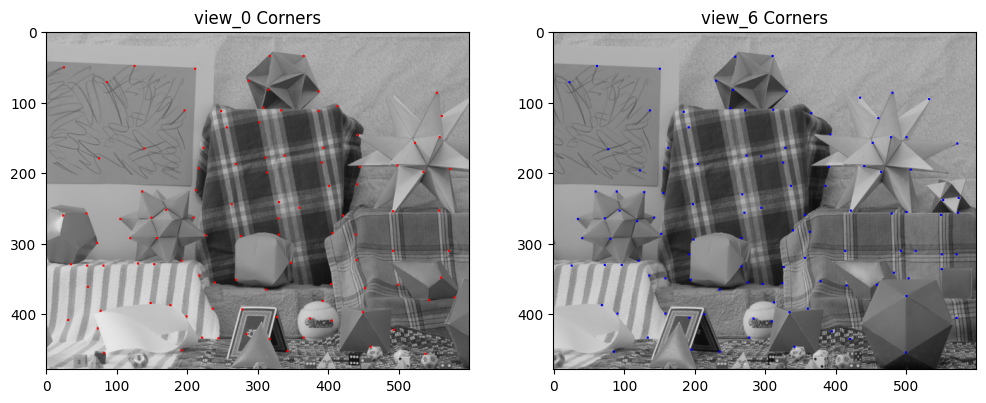

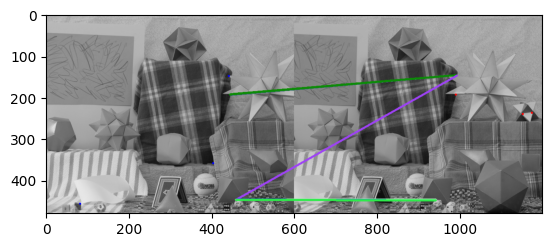

In [22]:
im = interest_points_matching(view0, view6, True, patch_from_im, 40, (9, 9), colors, -1, 0.2)

**No filtering, same parameters example**

corners amount: 954
corners amount: 1026


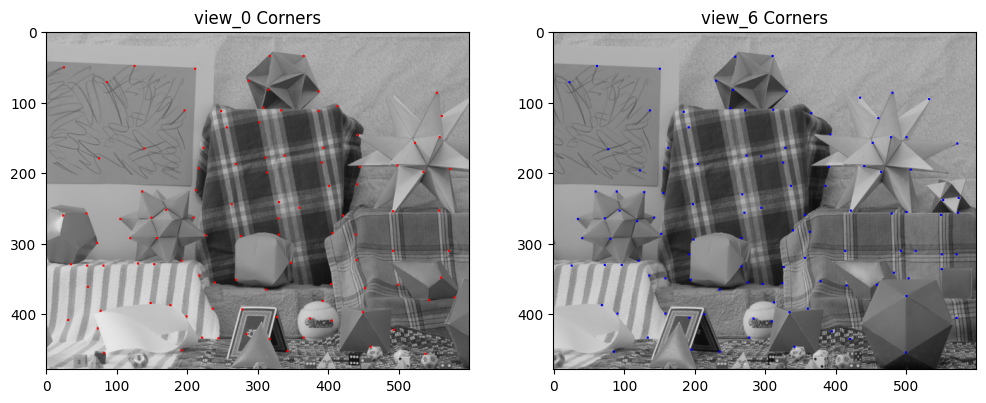

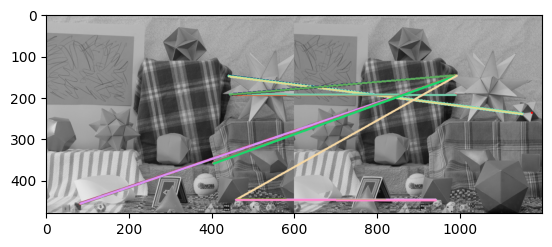

In [23]:
im = interest_points_matching(view0, view6, True, patch_from_im, 40, (9, 9), colors, -1, -1)

##**B.5**
**Histogram vs Gradient based descriptors**

As visualized below, gradient based descriptor missed the blue circled matching.
Why assume that in the left image, gradients were stronger in comparison to the right image.

In the left image, the sharp object's tip is the detected corner,
And in the right image the intersect between the shirt and the sharp object's edge is the corner.

Using a histogram based descriptors, comparing pixel values of similar environments result in small ssd distance.

However, using gradient based descriptors, where in this case the gradients are significantly different due to the corners detected, result in larger ssd distance.

corners amount: 954
corners amount: 1026
corners amount: 954
corners amount: 1026


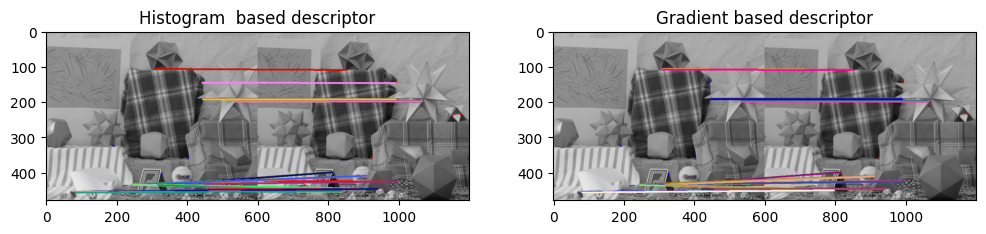

In [24]:
hist_desc_im = interest_points_matching(view0, view6, True, hist_patch_im, 120, (9, 9), colors, 30, -1, False)
grad_desc_im = interest_points_matching(view0, view6, True, gradient, 120, (9, 9), colors, 30, -1, False)

fig, axes = plt.subplots(1, 2, figsize=(12, 9))
axes[0].imshow(hist_desc_im)
axes[0].set_title("Histogram  based descriptor")
axes[1].imshow(grad_desc_im)
axes[1].set_title("Gradient based descriptor")
plt.show()

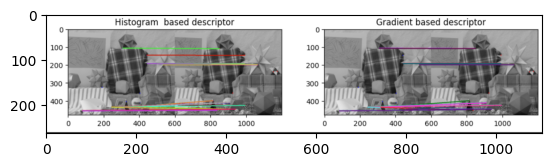

In [25]:

grad_vs_hist = plt.imread("./images/grad_vs_hist.png")
plt.title("")
plt.imshow(grad_vs_hist)
plt.show()

**SSD vs NCC**


No significant differences were found using ncc similarity vs ssd distance.

However, when darkening was applied, ncc stayed consistent in comparison to SSD.

This is because ncc measures the cosine similarity between descriptors, which is not affected by pixel values.

**Note**: No y-thresholding was applied here, in order to get false matches, and check for inconsistencies.

corners amount: 954
corners amount: 1026
corners amount: 954
corners amount: 1026


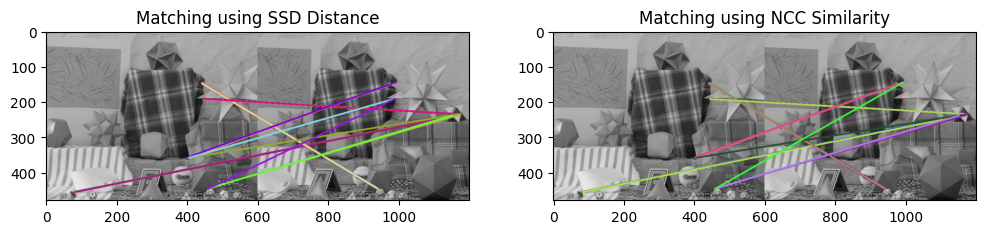

corners amount: 954
corners amount: 1017
corners amount: 954
corners amount: 1017


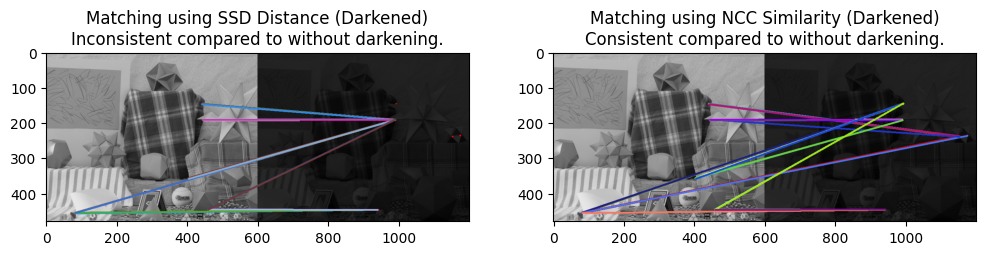

In [26]:
ssd_im = interest_points_matching(view0, view6, True, hist_patch_im, 40, (9, 9), colors, -1, -1, False)
ncc_im = interest_points_matching(view0, view6, False, hist_patch_im, 40, (9, 9), colors, -1, -1, False)

fig, axes = plt.subplots(1, 2, figsize=(12, 9))
axes[0].imshow(ssd_im)
axes[0].set_title("Matching using SSD Distance")
axes[1].imshow(ncc_im)
axes[1].set_title("Matching using NCC Similarity")
plt.show()

view6_dark = (view6 / 5).astype(np.uint8)

ssd_im_dark = interest_points_matching(view0, view6_dark, True, gradient, 40, (9, 9), colors, -1, -1, False)
ncc_im_dark = interest_points_matching(view0, view6_dark, False, gradient, 40, (9, 9), colors, -1, -1, False)

fig, axes = plt.subplots(1, 2, figsize=(12, 9))
axes[0].imshow(ssd_im_dark)
axes[0].set_title("Matching using SSD Distance (Darkened)\nInconsistent compared to without darkening.")
axes[1].imshow(ncc_im_dark)
axes[1].set_title("Matching using NCC Similarity (Darkened)\nConsistent compared to without darkening.")
plt.show()

**Matching Consistensy Comparison**

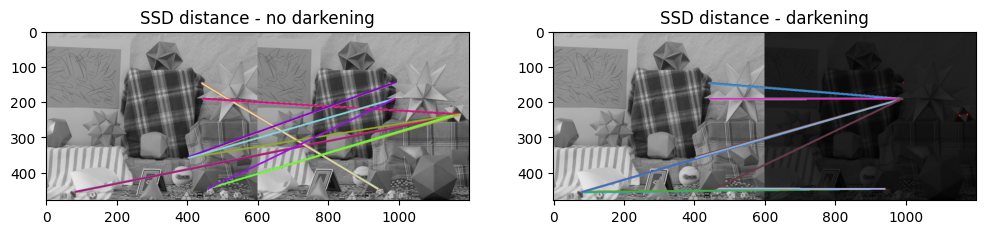

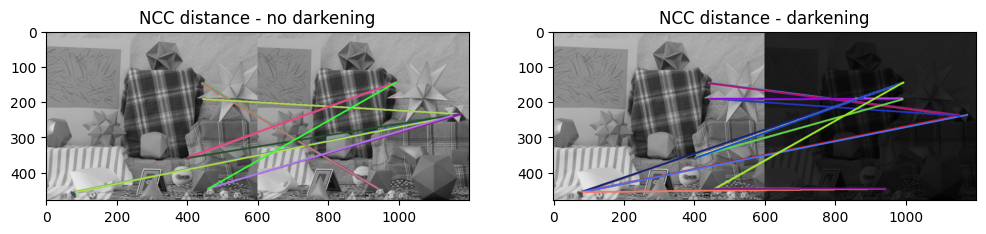

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 9))
axes[0].imshow(ssd_im)
axes[0].set_title("SSD distance - no darkening")
axes[1].imshow(ssd_im_dark)
axes[1].set_title("SSD distance - darkening")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 9))
axes[0].imshow(ncc_im)
axes[0].set_title("NCC distance - no darkening")
axes[1].imshow(ncc_im_dark)
axes[1].set_title("NCC distance - darkening")
plt.show()

#**B.6**
Visualization of incorrect matched points in each of the previous sections.

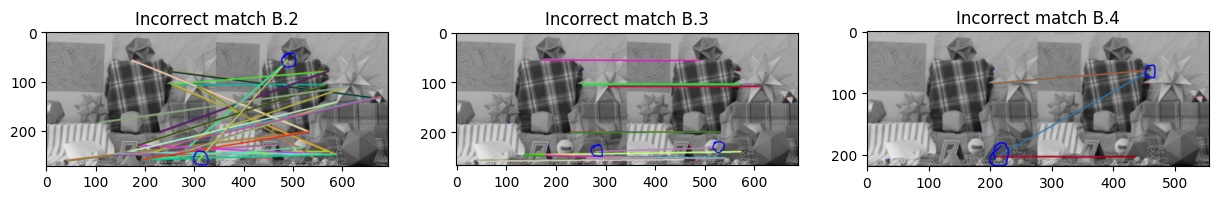

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 9))

im1 = plt.imread("./images/incorrect_b2.png")
im2 = plt.imread("./images/incorrect_b3.png")
im3 = plt.imread("./images/incorrect_b4.png")

axes[0].imshow(im1)
axes[0].set_title("Incorrect match B.2")
axes[1].imshow(im2)
axes[1].set_title("Incorrect match B.3")
axes[2].imshow(im3)
axes[2].set_title("Incorrect match B.4")
plt.show()

**Implementation details**

You can compute the NCC or SSD patch by patch. This will probably takes longer than using matrix multiplications of numpy.

Using matrices:
1. Generate a 1D vector from each descriptor.


2. Generate a matrix $M_1$:  rows  are  the descriptors of img1.


3. Generate a matrix $M_2$:  columns  are  the descriptors of img2.


4. $M=np.matmul(M_1,M_2)$\
   * what is the value in $M(i,j)$?


5. Think of how to normalize the set of patches, if you need.
   * You can consider using the function np.diag(np.diag(matrix)) as part of your solution.
    
    

## Part C ##

In this part you will compute the 3D structure from a pair of rectified images.


**The input:**\
    **a.** A pair of two rectified images, $im1$ and $im2$ (*view1.png and view5.png*).\
    **b.** A window size $(s_x,s_y$).\
    **c.** Disparity range $(d_{min},d_{max})$ (see below).

**The output:**\
**a.** A matrix, $D$ with the disparity map for the left image.\
**b.** Three matrices X, Y, Z with the x, y, z-coordinates of each pixel in the left image. Assign zero for pixels for which the disparity was not computed.

Note: all matrices $im1, im2, D, X, Y, Z$ have the same dimensions.

**Instructions:**
1. Read the two images view1.png and view5.png, and apply the functions to this pair of images.

   
2. Write a function that receives two rectified images, and compute dense matching along lines with the same $y-$coordinate.
    * You can use any of the descriptors from Part B. The patch size should be given as a parameter.
    * Use NCC for the similarity measure.
    * You can assume that you are given the range of disparities, $d_{min},d_{max}$ as an input. \
      For example, if  $(d_{min},d_{max})=(20,120)$ it follows that the corresponding point of  $(x,y)$ in the left image, is in the range $(x-120:x-20,y)$ in the right image.
    * Consider matching with and without order preseving.
    * List all parameters you use for your function.
    * Hints on efficient implementation is given below.
    
        
3. Write a function that computes the disparity based on (2).  
    * **Display** the disparity $D$ map as an image
   
  
4. Compute the depth map using the disparity.
    * Assume that scaled focal lengths ($f$ in the presentation) are $α_x=α_y=1$.
    * The distance between the cameras is 160mm.
    * Add to your disparity depth map the value 100, since images were cropped.
    * Display the disparity as an image.
   

4. Compute the matrices X,Y,Z
    * Present the object given by X,Y,Z using a 3D plot.


**Implementation**\
You can implement the computation of the similarity and the disparity directly by an exhaustive search. You can also use the idea from Part B. A more efficeint and elegant way is described below. You are welcome to try, but you do not have to.


General idea for the **vectorized solution** (you will need to fill in the gaps):
* Let $w$ and $h$ we the width and the height of the image respectively.
* First assume that the patch size is $1\times s_y$.
* Given two $1\times w$ rows, $r_1$ and $r_2$ which are corresponding rows of the two images. Compute the $w\times w$ matrix $R12=r_1^T r_2$. The values $R12(i,j)$ consists of the product of two pixels $r_1(i)\cdot r_2(j)$.
* Convolve $R12$ with the $s_y\times s_y$ identity matrix, $I_{s_y}$ : $Corr=I_{s_y}*R12$. The value $Corr(i,j)$ is the correlation of the $s_y$ 1D neighborhood of $r_1(i)$ and  $r_2(j)$.
* Think about how to normalize this correlation using the same idea. Hint, use the computation of $I_{s_y}*(r_1^Tr_1)$ and $I_{s_y}*(r_2^Tr_2)$.
* For a general patch size, $s_x\times s_y$, define $R$ to be 3D matrix of size $h\times w\times s_x$ and use 3D mask for the convolution.
* Up to here, we considered each row seperately, hence we need to loop over all rows of the images. There is a way to do it without looping, but not in this assignemnt :)


#**C.1**
Reading images view1, view5

In [29]:
view1 = cv2.imread('./images/view1.tif')
view5 = cv2.imread('./images/view5.tif')

view1_gray = cv2.cvtColor(view1,cv2.COLOR_BGR2GRAY).astype(np.int64)
view5_gray = cv2.cvtColor(view5,cv2.COLOR_BGR2GRAY).astype(np.int64)

#**C2**

**Set of parameters**
- Gradient based descriptors
- Window Size = (11, 11)
- ($d_{min}, d_{max}$) = (20, 120)

In [30]:
def desperity_map(img1, img2, window_size, disparity_range):
    img1 = img1.copy()
    img2 = img2.copy()
    height, width = img1.shape
    d_min, d_max = disparity_range
    desperity = np.zeros((height, width))

    for row_index in range(height):

        img1_patches = np.vstack([gradient(img1, (row_index, col_index), window_size) for col_index in range(width)])
        img2_patches = np.hstack([gradient(img2, (row_index, col_index), window_size).reshape(-1, 1) for col_index in range(width)])

        corr = img1_patches @ img2_patches

        img1_patch_norm = np.sqrt(np.diag(img1_patches @ img1_patches.T))
        img2_patch_norm = np.sqrt(np.diag(img2_patches.T @ img2_patches))

        # avoid division by zero
        epsilon = 1e-6
        img1_patch_norm = np.where(img1_patch_norm == 0, epsilon, img1_patch_norm)
        img2_patch_norm = np.where(img2_patch_norm == 0, epsilon, img2_patch_norm)

        img1_patch_norms_grid, img2_patch_norms_grid = np.meshgrid(img1_patch_norm, img2_patch_norm, indexing='ij')
        norm  = img1_patch_norms_grid * img2_patch_norms_grid

        ncc = corr / norm

        # remove values outside the disparity range
        i_x = np.arange(ncc.shape[0])[:, None]
        i_y = np.arange(ncc.shape[1])
        ncc[(i_y < i_x - d_max) | (i_y > i_x - d_min)] = 0.0

        max_indices = np.argmax(ncc, axis=1).reshape(1,-1)

        desperity[row_index] =  np.arange(max_indices.shape[1]) - max_indices

    return desperity

#**C.3**
**Display disparity map**

In [31]:
desperity = desperity_map(view1_gray, view5_gray, (11,11), (20,120))


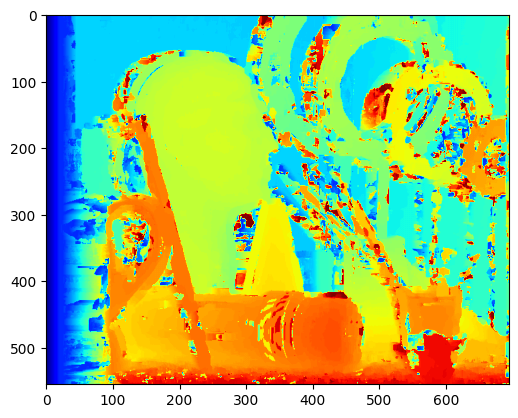

In [32]:
plt.imshow(desperity, cmap='jet')
plt.show()

#**C.4**
**Display depth map**

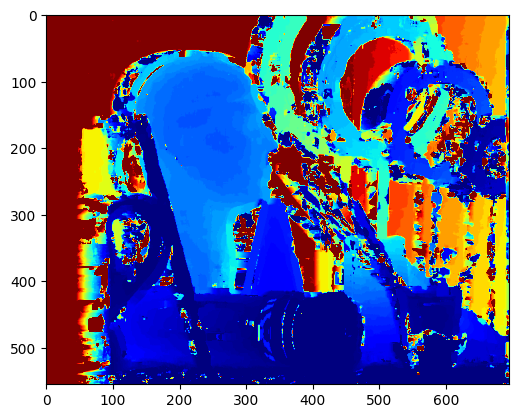

In [33]:
def depth_map(desperity):
    focal_length=1
    cameras_distance=160
    desperity = np.where(desperity == 0, 1e-6, desperity) # avoid deviding by zero
    depth_map = (focal_length * cameras_distance) / desperity + 100
    return depth_map

depth = depth_map(desperity)
min, max = np.percentile(depth, [15, 85])
plt.imshow(depth, cmap='jet', vmin=min, vmax=max)
plt.show()

# **C.5**
**3d Reconstruction by Depth Map**

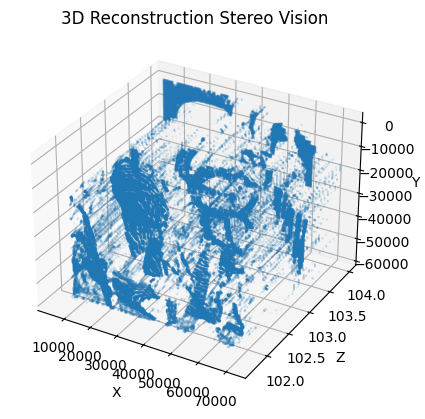

In [34]:
depth_min, depth_max = np.percentile(depth, [10, 85])
depth = np.where((depth < depth_min) | (depth > depth_max), np.nan, depth)

Z = np.copy(depth)

height, width = depth.shape
x, y = np.meshgrid(np.arange(width), np.arange(height))

Y = (y * Z)
X = (x * Z)

X= X.flatten()
Y= Y.flatten()
Z= Z.flatten()

fig = plt.figure()
axs= fig.add_subplot(projection='3d')

axs.scatter(X, Z, -Y,  marker='.', s=0.01)

axs.set_xlabel('X')
axs.set_ylabel('Z')
axs.set_zlabel('Y')
axs.set_title('3D Reconstruction Stereo Vision')
plt.show()